In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../../')
import ndrought.drought_network as dnet
import ndrought.wrangle_v11 as dnw

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

import os

/pool0/data/steinjao/drought/drought_impact/notebooks/analysis/drought_tracks/../../../ndrought/wrangle.py:17: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
cwd = '/pool0/home/steinadi/data/drought/drought_impact/data/thresh_experiments'

In [3]:
test_dtd_old = dnw.convert_pickle_to_dtd(f'{cwd}/spi30d/track/track_2800a_09r_1m.pickle')

In [4]:
test_dtd = test_dtd_old

In [5]:
new_x = []
for track in test_dtd['x']:
    if len(track) > 0:
        new_x.append(track)

In [6]:
for key in test_dtd.keys():
    var_tracks = test_dtd[key]
    trimmed_tracks = []
    for track in var_tracks:
        if len(track) > 0:
            trimmed_tracks.append(track)
    test_dtd[key] = trimmed_tracks

In [7]:
test_summ, test_summ_grp = dnw.compute_track_summary_characterization(test_dtd, 5)

In [8]:
test_summ

,lifetime,distance,displacement,average velocity,similarity,xy_size,uv_size
0,5,8.014812e+05,712884.456813,1.602962e+05,0.451215,"[5050, 78200]","[78200, 93334]"
1,5,7.432056e+05,500829.534176,1.486411e+05,0.445396,"[4140, 78200]","[78200, 93334]"
2,20,7.877706e+05,750730.700255,3.938853e+04,0.775824,"[9999, 10457, 48842, 60219, 63784]","[10457, 48842, 60219, 63784, 66885]"
3,15,4.364986e+05,249503.362585,2.909990e+04,0.692970,"[3080, 48842, 60219, 63784]","[48842, 60219, 63784, 66885]"
4,15,9.552266e+05,732008.284168,6.368177e+04,0.692678,"[3023, 48842, 60219, 63784]","[48842, 60219, 63784, 66885]"
...,...,...,...,...,...,...,...
536,0,1.886142e+05,188614.198356,inf,0.537215,[5637],[10493]
537,10,8.124789e+05,690240.296501,8.124789e+04,0.653193,"[6197, 60509, 56439]","[60509, 56439, 61053]"
538,10,6.819899e+05,590820.099702,6.819899e+04,0.658823,"[7219, 60509, 56439]","[60509, 56439, 61053]"
539,5,1.028960e+06,926845.923263,2.057920e+05,0.264291,"[4987, 17033]","[17033, 72236]"


In [9]:
bins=[0, 30, 60, 90, 180, 365, 730, 1825, 7*1163]

In [10]:
test_grp_obj = test_summ.groupby(pd.cut(test_summ.lifetime, bins=bins))

In [11]:
group_keys = [key for key in test_grp_obj.groups.keys()]

In [12]:
def groupby_intervals(data:pd.DataFrame, bins=[0, 30, 60, 90, 180, 365, 730, 1825, 7*1163]):
    grp_obj = data.groupby(pd.cut(data.lifetime, bins=bins))
    keys = [key for key in grp_obj.groups.keys()]
    return grp_obj, keys

In [13]:
track_dir = f'{cwd}/spi30d/track'

In [14]:
files = os.listdir('/pool0/home/steinadi/data/drought/drought_impact/data/thresh_experiments/spi30d/track')

In [15]:
all_dtd = {}
all_summ = {}
all_summ_grp = {}
all_grp_obj = {}

for file in files:
    dtd = dnw.convert_pickle_to_dtd(f'{track_dir}/{file}')
    for key in dtd.keys():
        var_tracks = dtd[key]
        trimmed_tracks = []
        for track in var_tracks:
            if len(track) > 0:
                trimmed_tracks.append(track)
        dtd[key] = trimmed_tracks
    dtd = dnw.prune_tracks(dtd)

    summ, summ_grp = dnw.compute_track_summary_characterization(dtd, 5)
    grp_obj, __ = groupby_intervals(summ)

    all_dtd[file] = dtd
    all_summ[file] = summ
    all_summ_grp[file] = summ_grp
    all_grp_obj[file] = grp_obj

I want to make a matrix of values and plot them as either a heatmap or 3d map

first I need to get the parameters out of the file names

In [16]:
# get area threshold
np.float64(files[0].split("_")[1][:-1])

2600.0

In [17]:
# get continuation threshold
np.float64(files[0].split("_")[2][:-1])/10

0.2

In [18]:
def get_thresh_from_file(file:str):
    arguments = file.split("_")
    a_thresh = np.float64(arguments[1][:-1])
    r_thresh = np.float64(arguments[2][:-1])/10
    return a_thresh, r_thresh

In [19]:
all_a_thresh = []
all_r_thresh = []

for file in files:
    a_thresh, r_thresh = get_thresh_from_file(file)
    all_a_thresh.append(a_thresh)
    all_r_thresh.append(r_thresh)

In [20]:
a_thresh_set = list(set(all_a_thresh))
a_thresh_set.sort()
r_thresh_set = list(set(all_r_thresh))
r_thresh_set.sort()

In [21]:
a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
a_thresh_map

{400.0: 0,
 600.0: 1,
 800.0: 2,
 1000.0: 3,
 1200.0: 4,
 1400.0: 5,
 1600.0: 6,
 1800.0: 7,
 2000.0: 8,
 2200.0: 9,
 2400.0: 10,
 2600.0: 11,
 2800.0: 12,
 3000.0: 13}

In [22]:
r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}
r_thresh_map

{0.0: 0,
 0.1: 1,
 0.2: 2,
 0.3: 3,
 0.4: 4,
 0.5: 5,
 0.6: 6,
 0.7: 7,
 0.8: 8,
 0.9: 9,
 1.0: 10}

In [23]:
empty_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))
empty_mat

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [24]:
all_grp_obj[files[0]].get_group(group_keys[2])['lifetime'].mean()

72.3529411764706

In [25]:
lifetime_mat = empty_mat.copy()

for file in files:
    try:
        lifetime_mean = all_grp_obj[file].get_group(group_keys[2])['lifetime'].mean()
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        lifetime_mat[i, j] = lifetime_mean
    except:
        pass

lifetime_mat

array([[75.64516129, 74.35897436, 74.21052632, 75.18518519, 71.66666667,
        70.38461538, 71.        , 65.        ,         nan,         nan,
                nan],
       [75.80645161, 73.67647059, 73.85714286,         nan, 70.78947368,
        71.        , 73.33333333, 65.        ,         nan,         nan,
                nan],
       [76.875     , 74.44444444, 75.15151515, 74.7826087 , 73.05555556,
        71.66666667, 73.33333333, 65.        ,         nan,         nan,
                nan],
       [75.625     , 74.21875   , 74.19354839, 74.77272727,         nan,
        72.5       , 77.5       ,         nan,         nan,         nan,
                nan],
       [75.        , 75.        , 75.        ,         nan, 75.3125    ,
        71.66666667, 73.33333333, 65.        ,         nan,         nan,
                nan],
       [75.75757576, 75.86206897, 74.65517241, 76.75      , 75.3125    ,
        71.66666667, 73.33333333, 65.        ,         nan,         nan,
              

/tmp/ipykernel_2105848/2925211843.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/2925211843.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


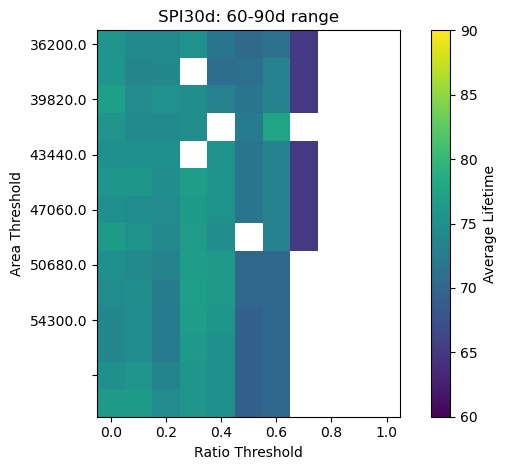

In [26]:
fig, ax = plt.subplots()

im = ax.imshow(lifetime_mat, vmin=60, vmax=90)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Average Lifetime')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

In [27]:
distance_mat = empty_mat.copy()

for file in files:
    try:
        distance_mean = all_grp_obj[file].get_group(group_keys[2])['distance'].mean()
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        distance_mat[i, j] = distance_mean
    except:
        pass

/tmp/ipykernel_2105848/1949306128.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/1949306128.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


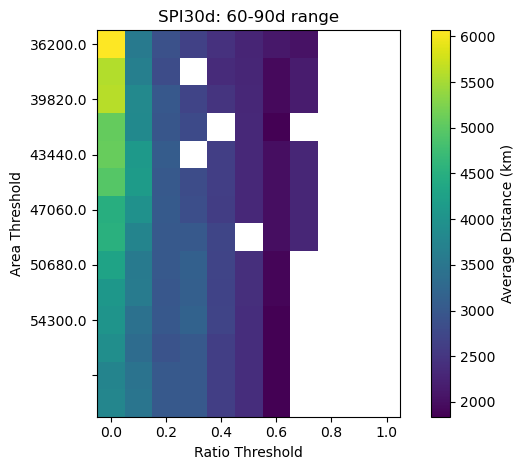

In [28]:
fig, ax = plt.subplots()

im = ax.imshow(distance_mat/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Average Distance (km)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

In [29]:
def get_mean_array(grp_obj, files, var):

    all_a_thresh = []
    all_r_thresh = []

    for file in files:
        a_thresh, r_thresh = get_thresh_from_file(file)
        all_a_thresh.append(a_thresh)
        all_r_thresh.append(r_thresh)

    a_thresh_set = list(set(all_a_thresh))
    a_thresh_set.sort()
    r_thresh_set = list(set(all_r_thresh))
    r_thresh_set.sort()
    a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
    r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}

    mean_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))

    for file in files:
        try:
            mean_val = grp_obj[file].get_group(group_keys[2])[var].mean()
            a_thresh, r_thresh = get_thresh_from_file(file)
            i = a_thresh_map[a_thresh]
            j = r_thresh_map[r_thresh]

            mean_mat[i, j] = mean_val
        except:
            pass

    return mean_mat

Double check this works

/tmp/ipykernel_2105848/166833654.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/166833654.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


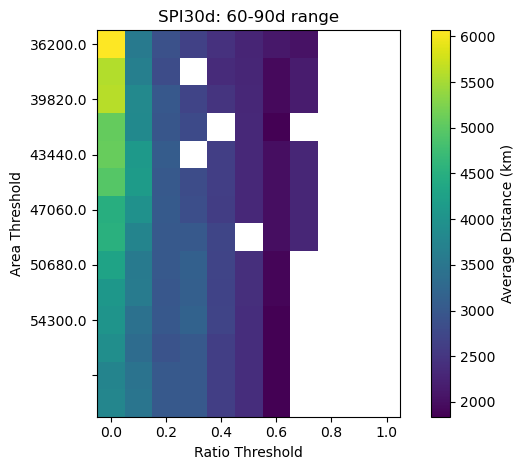

In [30]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_grp_obj, files, 'distance')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Average Distance (km)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

Yay

/tmp/ipykernel_2105848/3915119880.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/3915119880.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


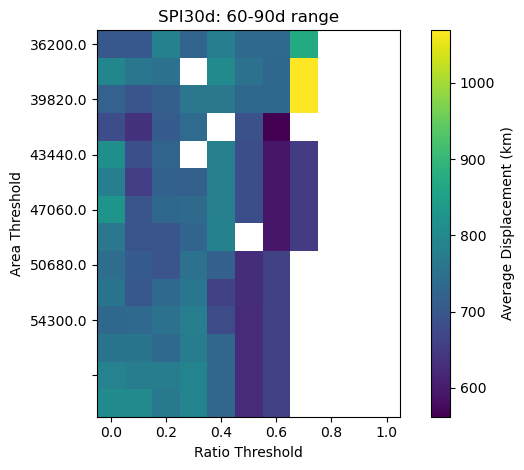

In [31]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_grp_obj, files, 'displacement')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Average Displacement (km)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/946327372.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/946327372.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


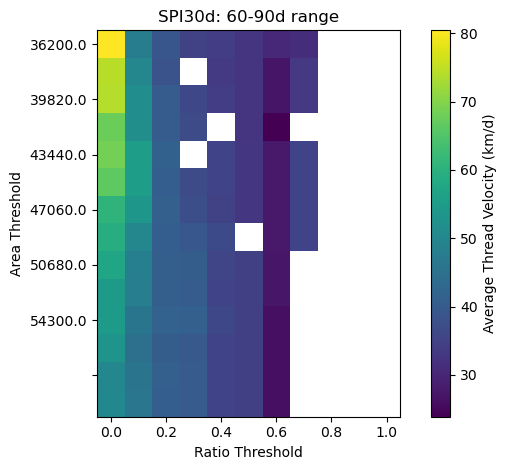

In [32]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_grp_obj, files, 'average velocity')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Average Thread Velocity (km/d)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/3345165952.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/3345165952.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


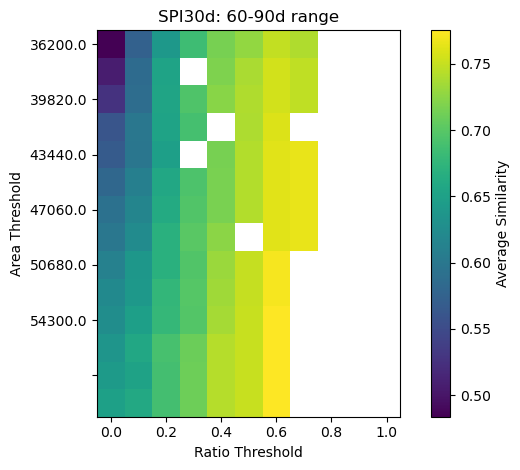

In [33]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_grp_obj, files, 'similarity'))
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Average Similarity')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/3910939703.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/3910939703.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


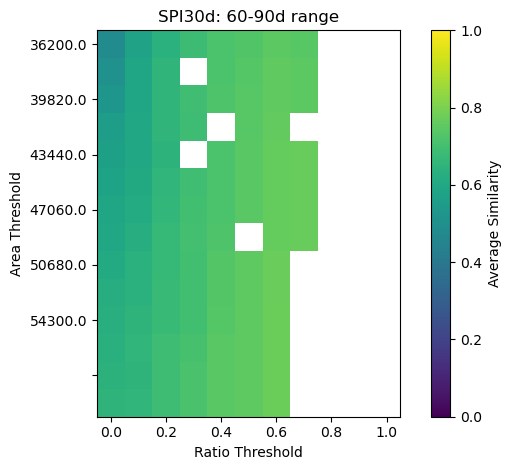

In [34]:
fig, ax = plt.subplots()

im = ax.imshow(get_mean_array(all_grp_obj, files, 'similarity'), vmin=0, vmax=1)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Average Similarity')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

In [35]:
def get_max_array(grp_obj, files, var):

    all_a_thresh = []
    all_r_thresh = []

    for file in files:
        a_thresh, r_thresh = get_thresh_from_file(file)
        all_a_thresh.append(a_thresh)
        all_r_thresh.append(r_thresh)

    a_thresh_set = list(set(all_a_thresh))
    a_thresh_set.sort()
    r_thresh_set = list(set(all_r_thresh))
    r_thresh_set.sort()
    a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
    r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}

    max_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))

    for file in files:
        try:
            max_val = grp_obj[file].get_group(group_keys[2])[var].max()
            a_thresh, r_thresh = get_thresh_from_file(file)
            i = a_thresh_map[a_thresh]
            j = r_thresh_map[r_thresh]

            max_mat[i, j] = max_val
        except:
            pass

    return max_mat

In [36]:
def get_min_array(grp_obj, files, var):

    all_a_thresh = []
    all_r_thresh = []

    for file in files:
        a_thresh, r_thresh = get_thresh_from_file(file)
        all_a_thresh.append(a_thresh)
        all_r_thresh.append(r_thresh)

    a_thresh_set = list(set(all_a_thresh))
    a_thresh_set.sort()
    r_thresh_set = list(set(all_r_thresh))
    r_thresh_set.sort()
    a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
    r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}

    min_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))

    for file in files:
        try:
            min_val = grp_obj[file].get_group(group_keys[2])[var].min()
            a_thresh, r_thresh = get_thresh_from_file(file)
            i = a_thresh_map[a_thresh]
            j = r_thresh_map[r_thresh]

            min_mat[i, j] = min_val
        except:
            pass

    return min_mat

## Maximums

/tmp/ipykernel_2105848/542001322.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/542001322.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


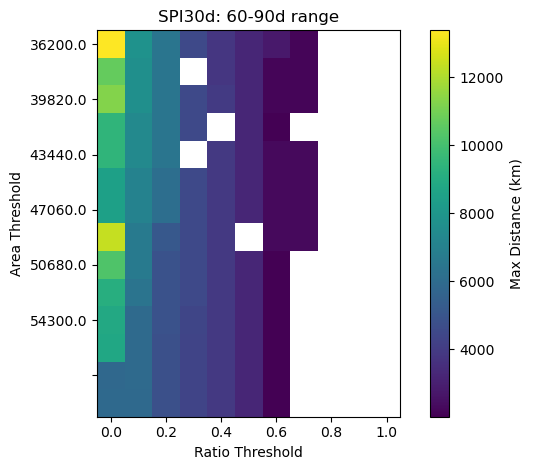

In [37]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_grp_obj, files, 'distance')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Max Distance (km)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/1259752536.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/1259752536.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


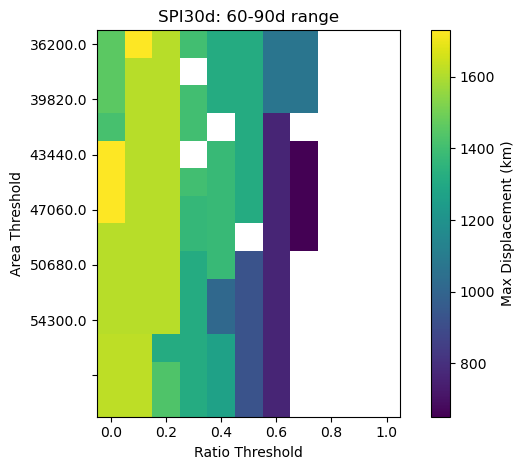

In [38]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_grp_obj, files, 'displacement')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Max Displacement (km)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/377930964.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/377930964.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


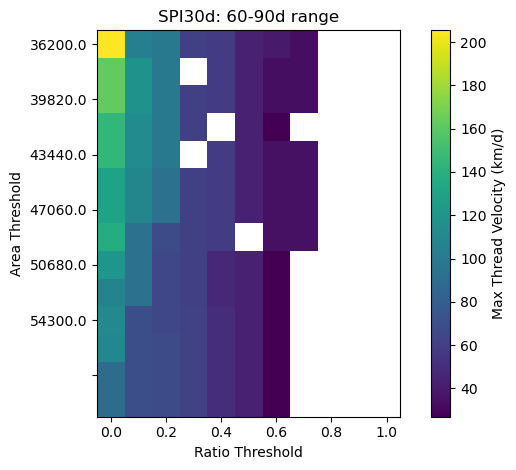

In [39]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_grp_obj, files, 'average velocity')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Max Thread Velocity (km/d)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/3192189025.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/3192189025.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


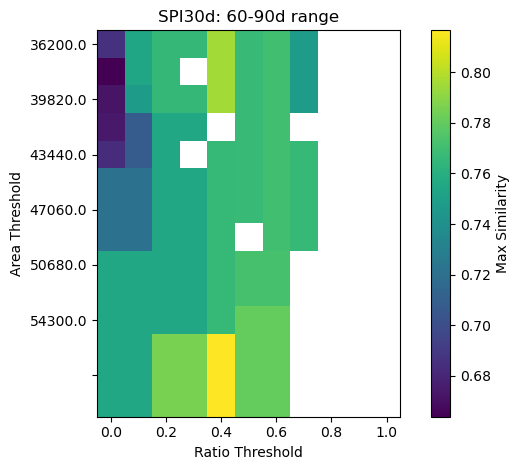

In [40]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_grp_obj, files, 'similarity'))
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Max Similarity')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/2626160263.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/2626160263.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


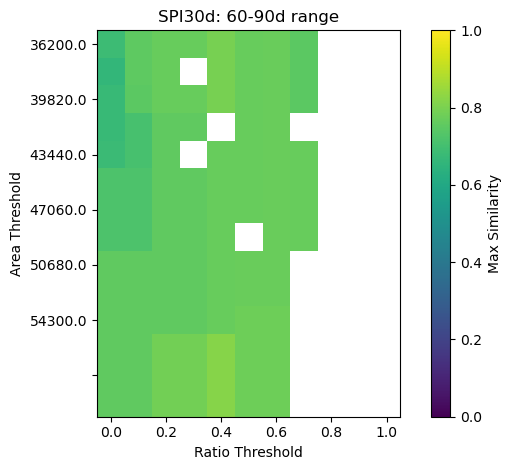

In [41]:
fig, ax = plt.subplots()

im = ax.imshow(get_max_array(all_grp_obj, files, 'similarity'), vmin=0, vmax=1)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Max Similarity')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

## Minimums

/tmp/ipykernel_2105848/2055554400.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/2055554400.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


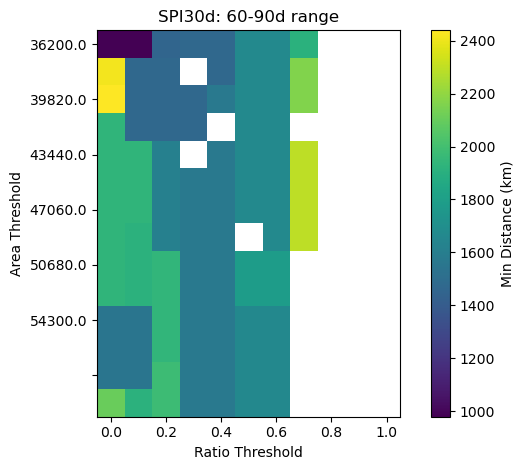

In [42]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_grp_obj, files, 'distance')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Min Distance (km)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/3748320833.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/3748320833.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


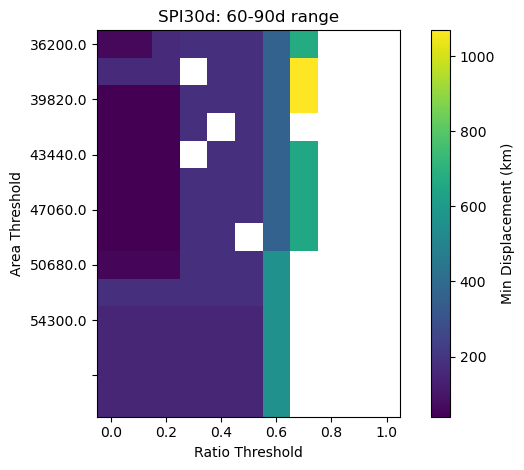

In [43]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_grp_obj, files, 'displacement')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Min Displacement (km)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/1904864946.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/1904864946.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


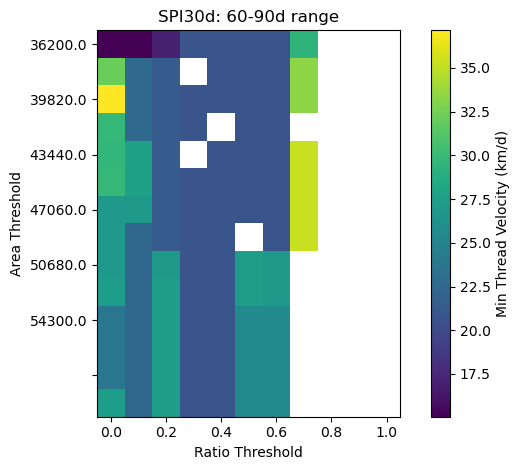

In [44]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_grp_obj, files, 'average velocity')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Min Thread Velocity (km/d)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/942892562.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/942892562.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


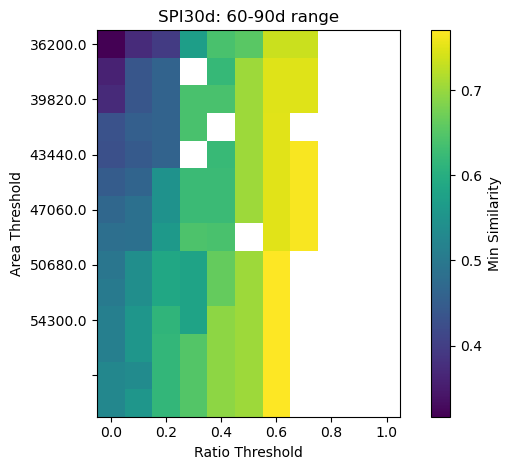

In [45]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_grp_obj, files, 'similarity'))
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Min Similarity')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/1405921459.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/1405921459.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


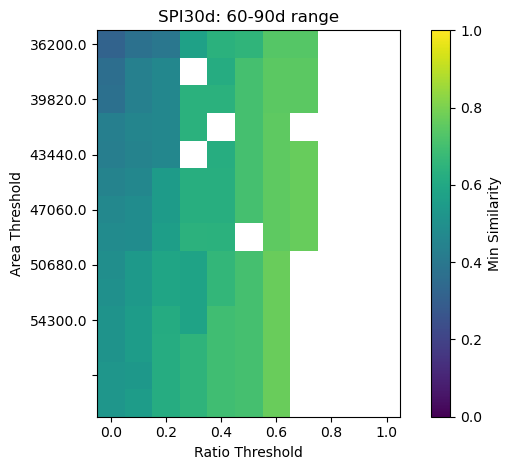

In [46]:
fig, ax = plt.subplots()

im = ax.imshow(get_min_array(all_grp_obj, files, 'similarity'), vmin=0, vmax=1)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='Min Similarity')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

## Standard Deviation

In [47]:
def get_std_array(grp_obj, files, var):

    all_a_thresh = []
    all_r_thresh = []

    for file in files:
        a_thresh, r_thresh = get_thresh_from_file(file)
        all_a_thresh.append(a_thresh)
        all_r_thresh.append(r_thresh)

    a_thresh_set = list(set(all_a_thresh))
    a_thresh_set.sort()
    r_thresh_set = list(set(all_r_thresh))
    r_thresh_set.sort()
    a_thresh_map = {a_thresh:i for i, a_thresh in enumerate(a_thresh_set)}
    r_thresh_map = {r_thresh:i for i, r_thresh in enumerate(r_thresh_set)}

    std_mat = np.nan * np.zeros((len(set(all_a_thresh)), len(set(all_r_thresh))))

    for file in files:
        try:
            std_val = grp_obj[file].get_group(group_keys[2])[var].std()
            a_thresh, r_thresh = get_thresh_from_file(file)
            i = a_thresh_map[a_thresh]
            j = r_thresh_map[r_thresh]

            std_mat[i, j] = std_val
        except:
            pass

    return std_mat

/tmp/ipykernel_2105848/3040924239.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/3040924239.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


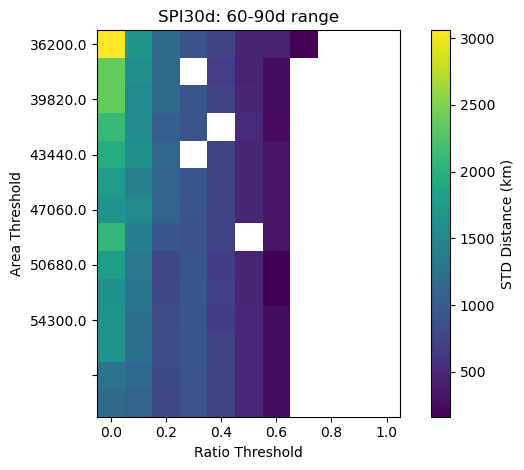

In [48]:
fig, ax = plt.subplots()

im = ax.imshow(get_std_array(all_grp_obj, files, 'distance')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='STD Distance (km)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/1702623778.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/1702623778.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


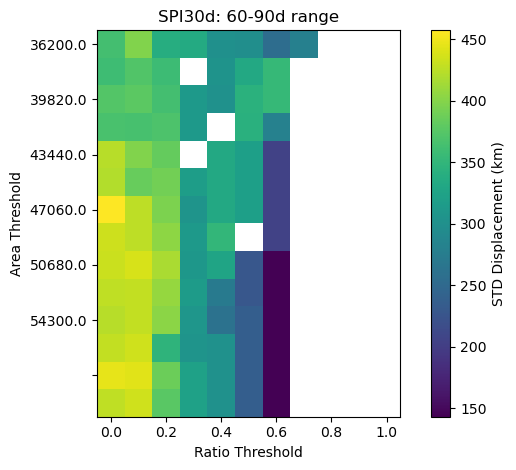

In [49]:
fig, ax = plt.subplots()

im = ax.imshow(get_std_array(all_grp_obj, files, 'displacement')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='STD Displacement (km)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/2246112559.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/2246112559.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


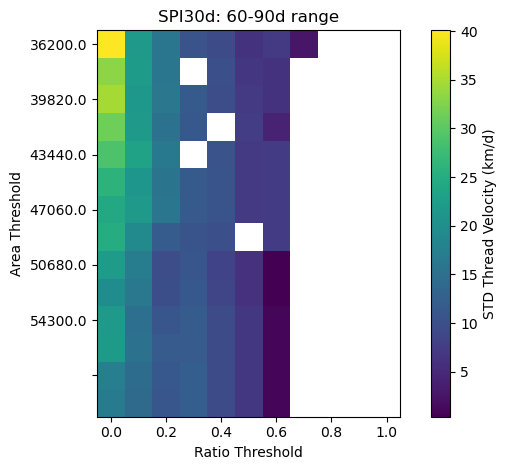

In [50]:
fig, ax = plt.subplots()

im = ax.imshow(get_std_array(all_grp_obj, files, 'average velocity')/1e3)
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='STD Thread Velocity (km/d)')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

/tmp/ipykernel_2105848/1071214555.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
/tmp/ipykernel_2105848/1071214555.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])


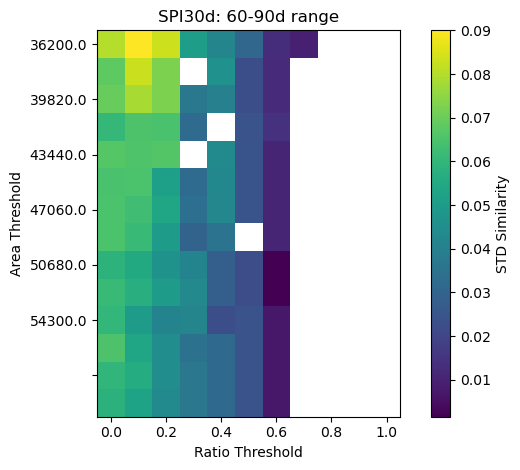

In [51]:
fig, ax = plt.subplots()

im = ax.imshow(get_std_array(all_grp_obj, files, 'similarity'))
ax.set_xticklabels([str(i.round(1)) for i in np.arange(-0.2, 1.1, 0.2)])
ax.set_yticklabels([str(i.round()) for i in 18.1*np.arange(1800, 3200, 200)])
fig.colorbar(im, label='STD Similarity')
ax.set_title('SPI30d: 60-90d range')
ax.set_ylabel('Area Threshold')
ax.set_xlabel("Ratio Threshold")
plt.tight_layout()

# Line Plots

In [52]:
mean_distance = get_mean_array(all_grp_obj, files, 'distance')
std_distance = get_std_array(all_grp_obj, files, 'distance')
max_distance = get_max_array(all_grp_obj, files, 'distance')
min_distance = get_min_array(all_grp_obj, files, 'distance')

/tmp/ipykernel_2105848/3035575683.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


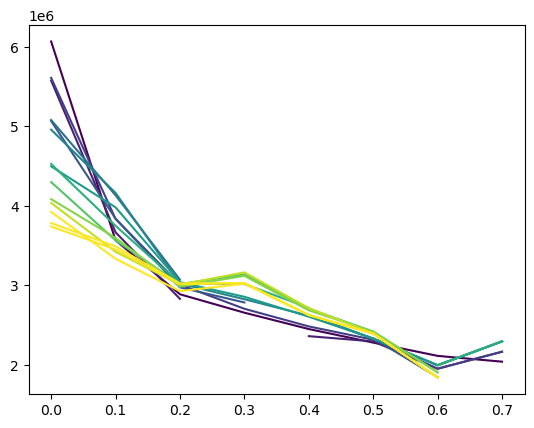

In [53]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

for i in np.arange(mean_distance.shape[0]):
    #ax.fill_between(r_thresh_set, mean_distance[i,:]+std_distance[i,:], mean_distance[i,:]-std_distance[i,:], color=cmap(i/mean_distance.shape[1]), alpha=0.1)
    #ax.fill_between(r_thresh_set, max_distance[i,:], min_distance[i,:], color=cmap(i/mean_distance.shape[1]), alpha=0.1)
    ax.plot(r_thresh_set, mean_distance[i,:], color=cmap(i/mean_distance.shape[1]))

/tmp/ipykernel_2105848/992416708.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


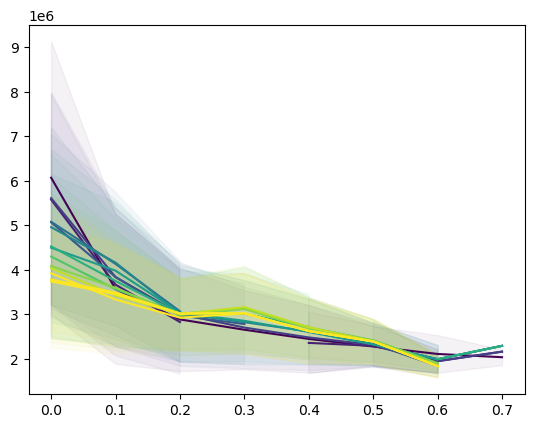

In [54]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

for i in np.arange(mean_distance.shape[0]):
    ax.fill_between(r_thresh_set, mean_distance[i,:]+std_distance[i,:], mean_distance[i,:]-std_distance[i,:], color=cmap(i/mean_distance.shape[1]), alpha=0.05)
    ax.plot(r_thresh_set, mean_distance[i,:], color=cmap(i/mean_distance.shape[1]))

So adding in +/- 1 std is really wild it seems

/tmp/ipykernel_2105848/3481781758.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


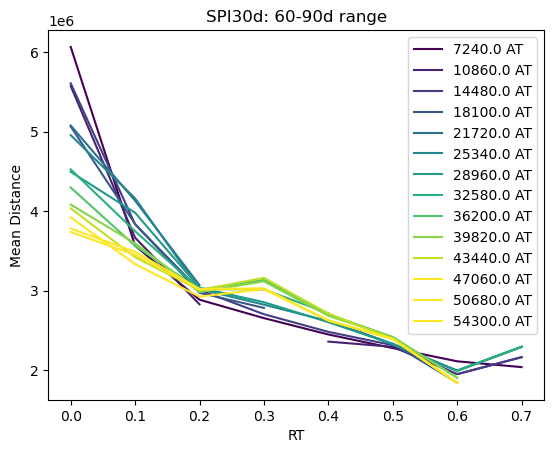

In [55]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_grp_obj, files, 'distance')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Distance')
    ax.set_title('SPI30d: 60-90d range')

/tmp/ipykernel_2105848/2795756974.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


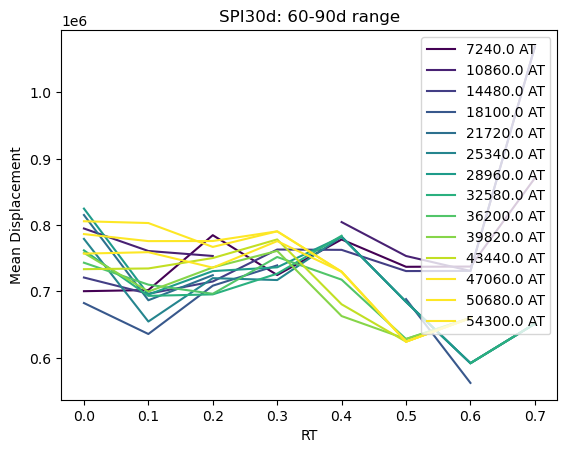

In [56]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_grp_obj, files, 'displacement')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Displacement')
    ax.set_title('SPI30d: 60-90d range')

/tmp/ipykernel_2105848/1754757158.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


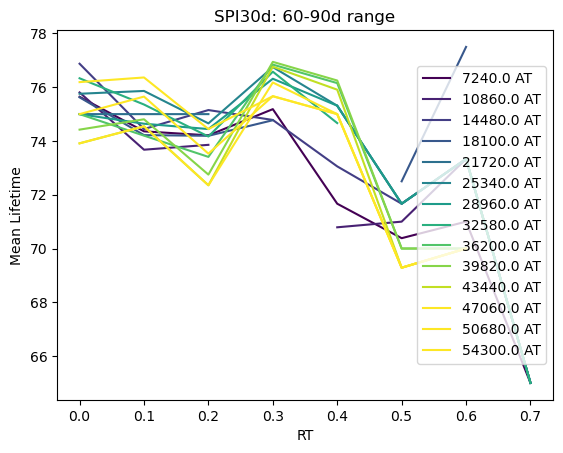

In [57]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_grp_obj, files, 'lifetime')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Lifetime')
    ax.set_title('SPI30d: 60-90d range')

/tmp/ipykernel_2105848/1065939389.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


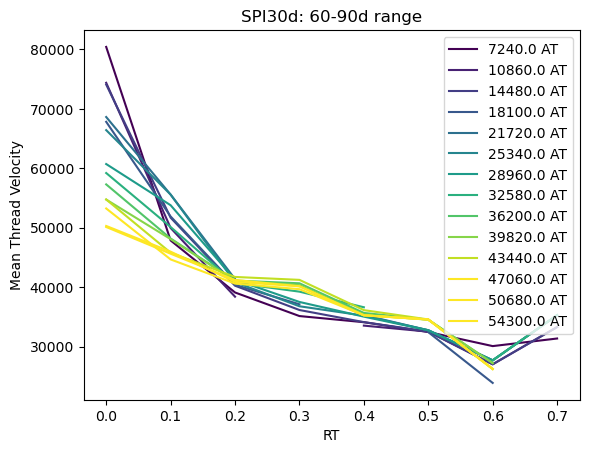

In [58]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_grp_obj, files, 'average velocity')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Thread Velocity')
    ax.set_title('SPI30d: 60-90d range')

/tmp/ipykernel_2105848/2910814794.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


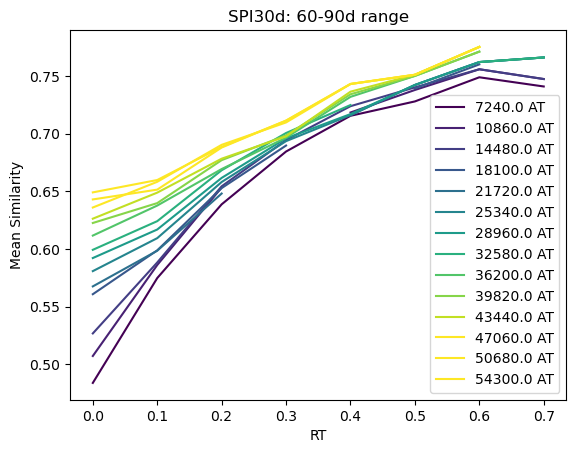

In [59]:
fig, ax = plt.subplots()

cmap = plt.cm.get_cmap('viridis')

mean_var = get_mean_array(all_grp_obj, files, 'similarity')

for i in np.arange(mean_var.shape[0]):
    ax.plot(r_thresh_set, mean_var[i,:], color=cmap(i/mean_var.shape[1]), label=f'{np.round(18.1*a_thresh_set[i])} AT')
    ax.legend()
    ax.set_xlabel('RT')
    ax.set_ylabel('Mean Similarity')
    ax.set_title('SPI30d: 60-90d range')

# CDFs

fig,ax = plt.subplots(empty_mat.shape[0], empty_mat.shape[1], figsize=(15,10))

for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['lifetime'].values)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]
    
    ax[i, j].plot(sorted, pos)
    ax[i,j].set_xlabel(r_thresh)
    ax[i,j].set_ylabel(np.round(a_thresh*18.1))

fig.suptitle('SPI30d CDFs: 60-90d range')
fig.supxlabel('Lifetime')
fig.supylabel('Quantile')

plt.tight_layout()

fig,ax = plt.subplots(empty_mat.shape[0], empty_mat.shape[1], figsize=(15,10))

for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['distance'].values/1e3)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]
    
    ax[i, j].plot(sorted, pos)
    ax[i,j].set_xlabel(r_thresh)
    ax[i,j].set_ylabel(np.round(a_thresh*18.1))

fig.suptitle('SPI30d CDFs: 60-90d range')
fig.supxlabel('Distance (km)')
fig.supylabel('Quantile')

plt.tight_layout()

fig,ax = plt.subplots(empty_mat.shape[0], empty_mat.shape[1], figsize=(15,10))

for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['displacement'].values/1e3)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]
    
    ax[i, j].plot(sorted, pos)
    ax[i,j].set_xlabel(r_thresh)
    ax[i,j].set_ylabel(np.round(a_thresh*18.1))

fig.suptitle('SPI30d CDFs: 60-90d range')
fig.supxlabel('Displacement (km)')
fig.supylabel('Quantile')

plt.tight_layout()

fig,ax = plt.subplots(empty_mat.shape[0], empty_mat.shape[1], figsize=(15,10))

for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['average velocity'].values/1e3)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]
    
    ax[i, j].plot(sorted, pos)
    ax[i,j].set_xlabel(r_thresh)
    ax[i,j].set_ylabel(np.round(a_thresh*18.1))

fig.suptitle('SPI30d CDFs: 60-90d range')
fig.supxlabel('Thread Velocity (km/d)')
fig.supylabel('Quantile')

plt.tight_layout()

fig,ax = plt.subplots(empty_mat.shape[0], empty_mat.shape[1], figsize=(15,10))

for file in files:
    sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['similarity'].values)
    a_thresh, r_thresh = get_thresh_from_file(file)
    i = a_thresh_map[a_thresh]
    j = r_thresh_map[r_thresh]
    
    ax[i, j].plot(sorted, pos)
    ax[i,j].set_xlabel(r_thresh)
    ax[i,j].set_ylabel(np.round(a_thresh*18.1))

fig.suptitle('SPI30d CDFs: 60-90d range')
fig.supxlabel('Similarity')
fig.supylabel('Quantile')

plt.tight_layout()

Hm. Those are a little hard to compare

Into the 4th dimension we go!

/tmp/ipykernel_2105848/251609409.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


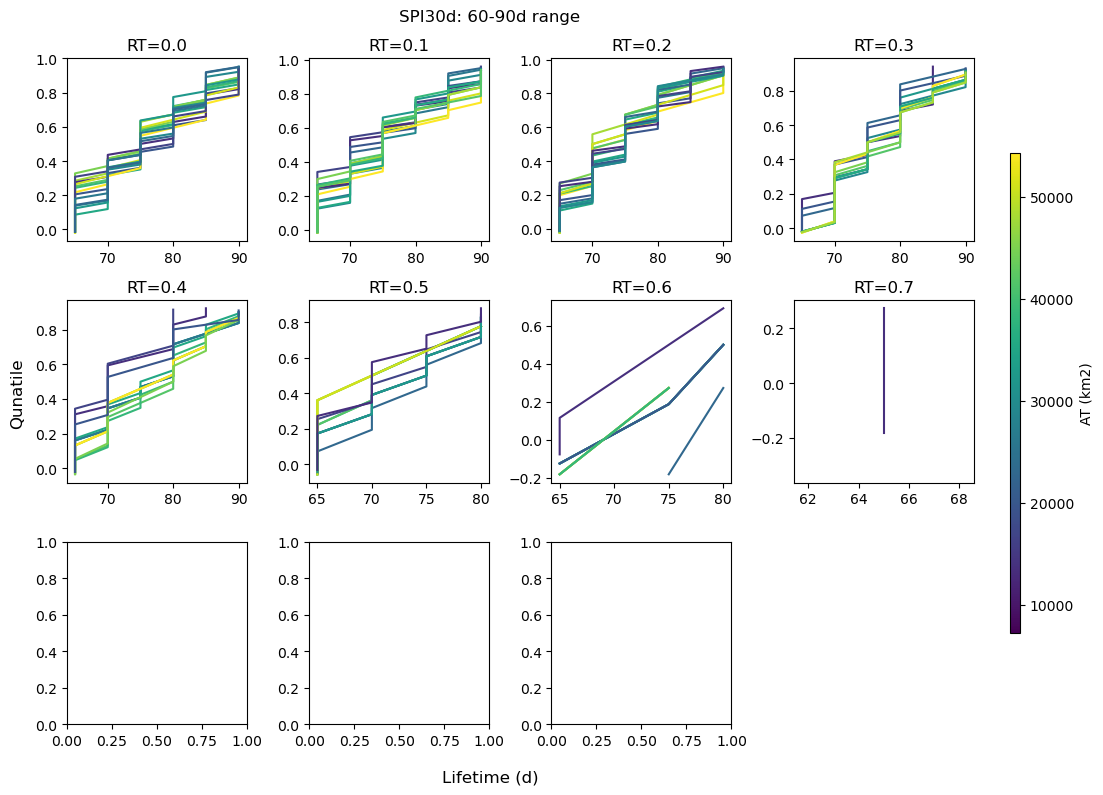

In [60]:
fig, axs = plt.subplots(3,4, figsize=(10,8))

ax_rav = axs.ravel()

for file in files:
    try:
        sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['lifetime'].values)
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
        ax_rav[j].set_title(f'RT={r_thresh}')
    except:
        pass

ax_rav[-1].axis('off')

fig.suptitle('SPI30d: 60-90d range')
fig.supxlabel('Lifetime (d)')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_2105848/3795452651.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


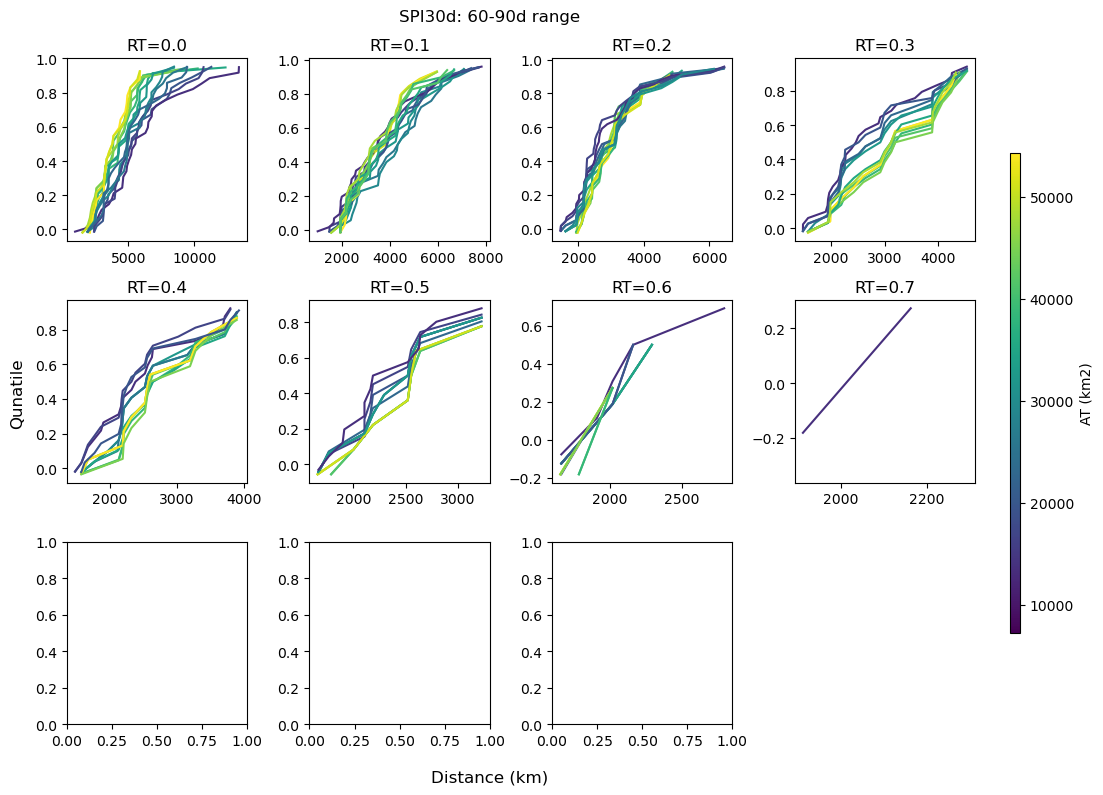

In [61]:
fig, axs = plt.subplots(3,4, figsize=(10,8))

ax_rav = axs.ravel()

for file in files:
    try:
        sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['distance'].values/1e3)
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
        ax_rav[j].set_title(f'RT={r_thresh}')
    except:
        pass

ax_rav[-1].axis('off')

fig.suptitle('SPI30d: 60-90d range')
fig.supxlabel('Distance (km)')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_2105848/1581460677.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


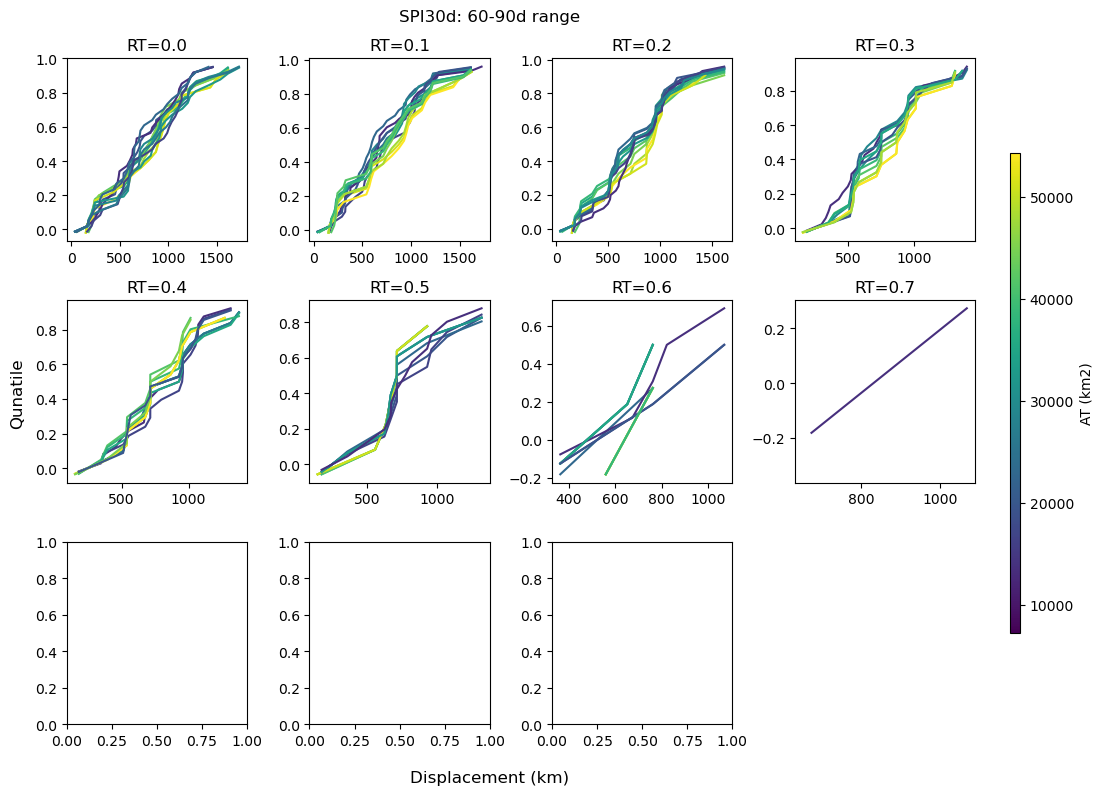

In [62]:
fig, axs = plt.subplots(3,4, figsize=(10,8))

ax_rav = axs.ravel()

for file in files:
    try:
        sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['displacement'].values/1e3)
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
        ax_rav[j].set_title(f'RT={r_thresh}')
    except:
        pass

ax_rav[-1].axis('off')

fig.suptitle('SPI30d: 60-90d range')
fig.supxlabel('Displacement (km)')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_2105848/1419620796.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


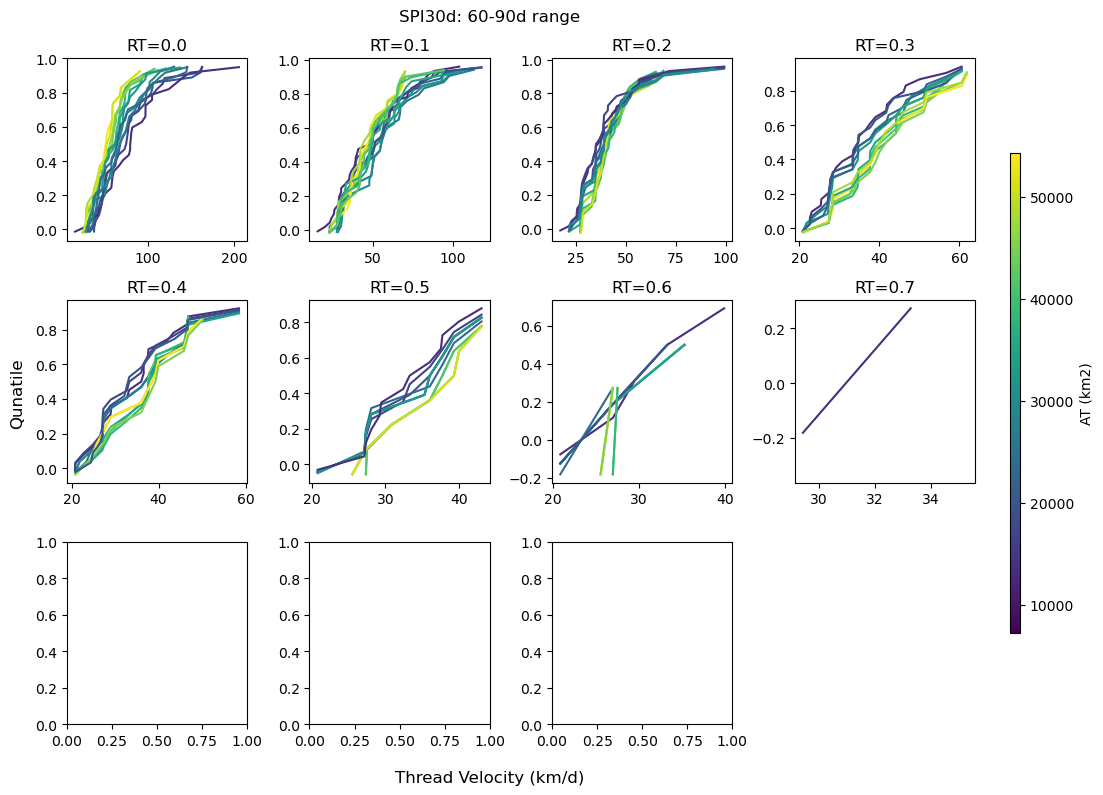

In [63]:
fig, axs = plt.subplots(3,4, figsize=(10,8))

ax_rav = axs.ravel()

for file in files:
    try:
        sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['average velocity'].values/1e3)
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
        ax_rav[j].set_title(f'RT={r_thresh}')
    except:
        pass

ax_rav[-1].axis('off')

fig.suptitle('SPI30d: 60-90d range')
fig.supxlabel('Thread Velocity (km/d)')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()

/tmp/ipykernel_2105848/1767674057.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


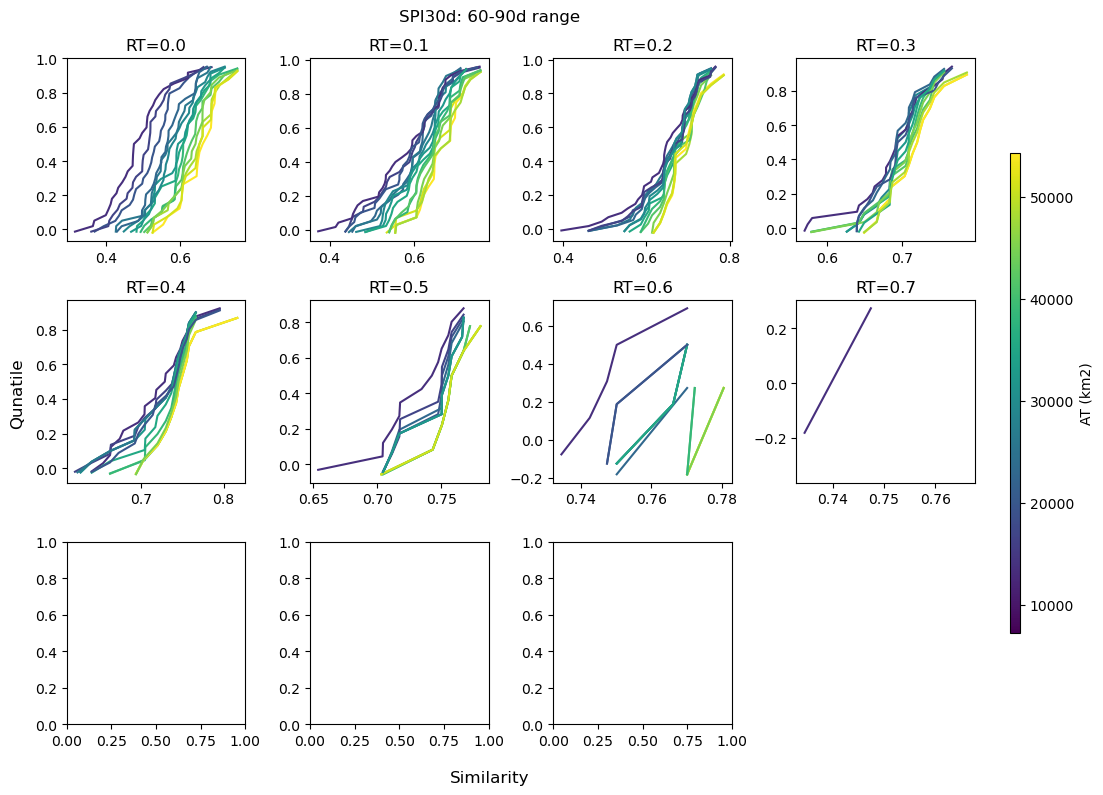

In [64]:
fig, axs = plt.subplots(3,4, figsize=(10,8))

ax_rav = axs.ravel()

for file in files:
    try:
        sorted, pos = dnw.cunnane_empircal_cdf(all_grp_obj[file].get_group(group_keys[2])['similarity'].values)
        a_thresh, r_thresh = get_thresh_from_file(file)
        i = a_thresh_map[a_thresh]
        j = r_thresh_map[r_thresh]

        ax_rav[j].plot(sorted, pos, color=cmap(a_thresh/np.max(a_thresh_set)))
        ax_rav[j].set_title(f'RT={r_thresh}')
    except:
        pass

ax_rav[-1].axis('off')

fig.suptitle('SPI30d: 60-90d range')
fig.supxlabel('Similarity')
fig.supylabel('Qunatile')

norm = mpl.colors.Normalize(vmin=18.1*np.min(a_thresh_set), vmax=18.1*np.max(a_thresh_set))

cax = fig.add_axes([1.02, 0.2, 0.01, 0.6])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='AT (km2)', location='right')

plt.tight_layout()